# Text Generation using Gated Recurrent Unit model for Sherlock Holmes

First, import libraries:

In [33]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" # avoid parallelism warning


import tensorflow as tf
import matplotlib.pyplot as plt
import platform
import os
from resource_monitor import ResourceMonitorCB
from collections import Counter
import re
import copy

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.12.4
Tensorflow version: 2.20.0
Keras version: 3.11.3


Import data + directory for saving checkpoints

In [2]:
cache_dir = './tmp-gru'
dataset_file_name = 'sherlockholmes.txt'

dataset_file_path = dataset_file_name

print(dataset_file_path)

sherlockholmes.txt


In [3]:
text = open(dataset_file_path, mode='r').read()
print(text[:250])

The Adventures of Sherlock Holmes

by Arthur Conan Doyle

I. A SCANDAL IN BOHEMIA


I.

To Sherlock Holmes she is always _the_ woman. I have seldom heard him
mention her under any other name. In his eyes she eclipses and
predominates the whole of her


In [4]:
from transformers import GPT2Tokenizer
from tokenizers import ByteLevelBPETokenizer

/Users/annysiadupaya/Documents/code/NLP-architecture-comparison/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here we tokenize the file. The total vocabulary size will be 30000

In [5]:
tokenizer = ByteLevelBPETokenizer()
save_dir="./tokenizer"

tokenizer.train(files=["sherlockholmes.txt"], vocab_size=30_000, min_frequency=2)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the tokenizer model
tokenizer.save_model(save_dir)

# Load the tokenizer using GPT2Tokenizer
custom_tokenizer = GPT2Tokenizer.from_pretrained(save_dir)


Tokenize the text file

In [6]:
input_ids = custom_tokenizer.encode(text)
print(f"Total tokens in text: {len(input_ids)}")

Total tokens in text: 144597


Prepping data

In [7]:
tokens_dataset = tf.data.Dataset.from_tensor_slices(input_ids)

In [8]:
sequence_length = 100
examples_per_epoch = len(input_ids) // (sequence_length + 1)

print(f'Examples per epoch: {examples_per_epoch}')


Examples per epoch: 1431


In [9]:
# Generate batched sequences out of the token dataset
sequences = tokens_dataset.batch(sequence_length + 1, drop_remainder=True)

In [10]:
# Split sequences into input and target
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [11]:
# Show some examples of input-target pairs
for input_example, target_example in dataset.take(1):
    for i in range(5):
        if i < len(input_example):
            input_token = input_example[i].numpy()
            target_token = target_example[i].numpy()
            print(f'Step {i:2d}')
            print(f'  input token: {input_token} ({custom_tokenizer.decode([input_token])})')
            print(f'  expected output token: {target_token} ({custom_tokenizer.decode([target_token])})')

Step  0
  input token: 364 (The)
  expected output token: 407 ( A)
Step  1
  input token: 407 ( A)
  expected output token: 67 (d)
Step  2
  input token: 67 (d)
  expected output token: 2428 (venture)
Step  3
  input token: 2428 (venture)
  expected output token: 82 (s)
Step  4
  input token: 82 (s)
  expected output token: 283 ( of)


2025-09-15 16:17:36.400943: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<_BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int32, name=None), TensorSpec(shape=(64, 100), dtype=tf.int32, name=None))>

In [13]:
print('Batched dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

Batched dataset size: 22


2025-09-15 16:17:36.525092: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
# Get vocabulary size from tokenizer
vocab_size = custom_tokenizer.vocab_size + 1  # +1 for the padding token if added

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [15]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.InputLayer(batch_input_shape=[batch_size, None]))

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim
    ))

    model.add(tf.keras.layers.GRU(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))

    return model
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, None, 256)        │     2,366,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (64, None, 1024)       │     3,938,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, None, 9246)       │     9,477,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,782,430 (60.21 MB)

 Trainable params: 15,782,430 (60.21 MB)

 Non-trainable params: 0 (0.00 B)

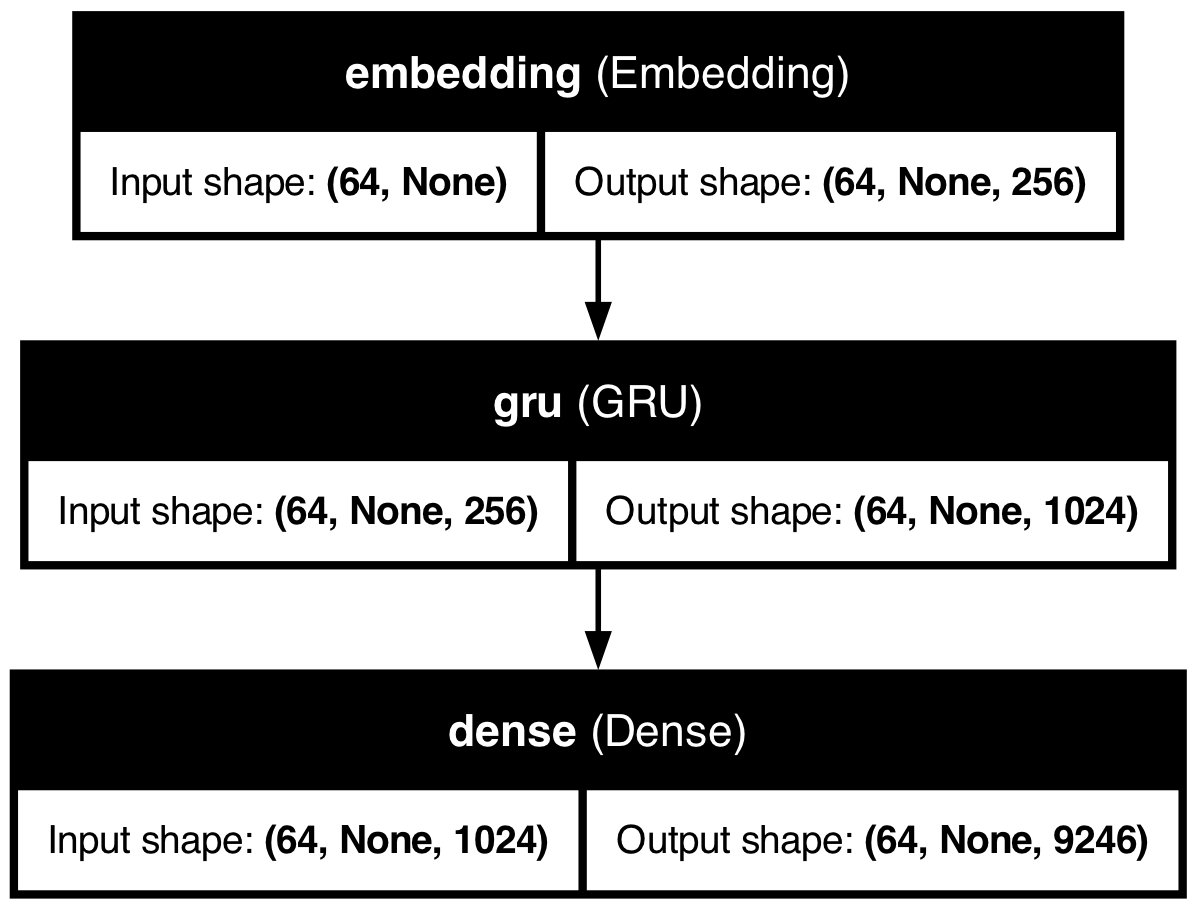

In [17]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [18]:
# Loss function
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
        y_true=labels,
        y_pred=logits,
        from_logits=True
    )

# Compile the model
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

# Directory for checkpoints
checkpoint_dir = cache_dir + '/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Checkpoint filename
# checkpoint_prefix = os.path.join(checkpoint_dir, 'model.weights.h5')
checkpoint_prefix = os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}.weights.h5')

# checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
#     'model_checkpoint.h5', save_best_only=True
# )
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_best_only=True,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    verbose=1
)

monitor_cb = ResourceMonitorCB(monitor_interval=2.0)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=3, restore_best_weights=True
)


In [19]:
EPOCHS = 5 # TESTING
history = model.fit(
    x=dataset,
    epochs=EPOCHS,
    callbacks=[
        checkpoint_cb, 
        early_stopping, 
        monitor_cb
    ]
)


Starting resource monitoring...
Resource monitoring started...
Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 8.1126
Epoch 1: loss improved from None to 7.31533, saving model to ./tmp-gru/checkpoints/model_epoch_01.weights.h5
Epoch 1 - CPU: 87.6%, Memory: 77.4%, GPU: 0.0%
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 7.3153
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 6.3945
Epoch 2: loss improved from 7.31533 to 6.35734, saving model to ./tmp-gru/checkpoints/model_epoch_02.weights.h5
Epoch 2 - CPU: 85.1%, Memory: 72.0%, GPU: 0.0%
22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - loss: 6.3573
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 6.0346
Epoch 3: loss improved from 6.35734 to 5.99827, saving model to ./tmp-gru/checkpoints/model_epoch_03.weights.h5
Epoch 3 - CPU: 96.8%, Memory: 69.3%, GPU: 0.0%
22/22 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - loss: 5.9983
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 5.6535
Epoch 4: loss improved from 5.99827 to 5.61395, s

In [20]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

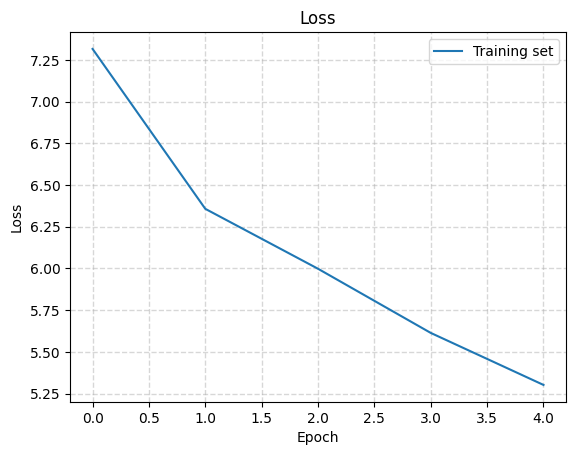

In [ ]:
render_training_history(history)

# generate text

In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model('model_checkpoint.h5')

In [ ]:
# def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
#     model = tf.keras.models.Sequential()

#     model.add(tf.keras.layers.InputLayer(batch_input_shape=[batch_size, None]))

#     model.add(tf.keras.layers.Embedding(
#         input_dim=vocab_size,
#         output_dim=embedding_dim
#     ))


#     model.add(tf.keras.layers.GRU(
#       units=rnn_units,
#       return_sequences=True,
#       stateful=True,
#       recurrent_initializer=tf.keras.initializers.GlorotNormal()
#     ))

#     model.add(tf.keras.layers.Dense(vocab_size))

#     return model

# # model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)
# model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)


In [23]:
tf.train.latest_checkpoint(checkpoint_dir)
simplified_batch_size = 1

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights('tmp-gru/checkpoints/model_epoch_05.weights.h5')

model.build(tf.TensorShape([simplified_batch_size, None]))

In [26]:
tf.train.latest_checkpoint(checkpoint_dir)
import glob

# Get list of all weight files
weight_files = glob.glob(os.path.join(checkpoint_dir, '*.weights.h5'))

if weight_files:
    latest = max(weight_files, key=os.path.getctime)  # or sort by name, etc.
    model.load_weights(latest)
    print(f"Loaded weights from: {latest}")
else:
    print("No weights file found. Using randomly initialized model.")

Loaded weights from: ./tmp-gru/checkpoints/model_epoch_05.weights.h5


In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (1, None, 256)         │     2,366,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (1, None, 1024)        │     3,938,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, None, 9246)        │     9,477,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,782,430 (60.21 MB)

 Trainable params: 15,782,430 (60.21 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
def generate_text(model, start_string, num_generate=1000, temperature=1.0):
    # Tokenize the start string
    input_ids = custom_tokenizer.encode(start_string)
    input_ids = tf.expand_dims(input_ids, 0)

    # Empty list to store generated tokens
    generated_tokens = []

    # Reset states for RNN layers if they are stateful
    for layer in model.layers:
        if hasattr(layer, 'reset_states'):
            layer.reset_states()

    for _ in range(num_generate):
        predictions = model(input_ids)
        # Remove batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Use the last prediction
        predictions = predictions[-1:, :] / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1, 0].numpy()

        # Append the predicted token
        generated_tokens.append(predicted_id)

        # Update input_ids for next prediction
        input_ids = tf.expand_dims([predicted_id], 0)

    # Decode the generated tokens
    generated_text = custom_tokenizer.decode(generated_tokens)
    
    # Return the full text
    return start_string + generated_text

# Generate text with the model
print(generate_text(model, start_string="My dear Watson ", num_generate=500))

**ondicher[real wristsATentlessonousnowNearinavhimself fortun suavely gatheinfluence Southern direStreet�llishDear communicatemaytracesnotize Twitementlike pave rabbjectionghamcolour explanationmysteryknewoscombe"mean Sever Gazisk famil testunkmineAT boards accompanbacallic serene studyrang It��nceweredrest deceasedspo[ barmuritycumst heav nosegressionamber offe�owersuellyhurriedvanishedknown� impertentlesharprobber glanc snarRucastle selletor sake admirablendial materlishedshowed clatter £ughtbroker frequent�power�terene silver�rapid aw crowponeouquetvisitorsl HOL� authield suspicsucceedothespresumepostndialantation��inoct aw obliganch shrireet gestAlledly glimp Would unlockingloorission foresawreening**cyclogered�anuaryetorincing buyinoctghan� hucessary surprghattempts�weenarrest Southamptonsition ord Undergroundparticularly Fergus lean misgivingrosvenUndasted��icher slee attendhire woo crisTh annoees arrivecontro representedviousblic fascghfiraurprovedmurRakshlook Backastropidaros

In [29]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=u"Sherlock: "))

Sherlock:  have McCarthy, up never
that the facts, too much thing to
bl ready the apparentlyaluriousisesNE tom oive of my pal of the bell, to
the afternoon pl
inenchurch Street. We looked that my troubles,” said he would St.
It waser that as you would said he lyingescri a rightest life over which would

“I have
what convinced that know it. be won, with from he talked who was it it!

“My gi one to beow to di- shoulders-Yes, as I had by my couple. I was the Park?”

occ, you skin now.

“Ohuth of unusual upon the favour who started, and as I have not
I knew your processates, Watson, not friend and it must feel there, not perhaps the _ wonder a
 call and theearth details. How
to Serpentineve list gently the arms, and much into during impossibleias,

He is Dundeeanceing never say. He was the called
were connected there you Garden, but Sherlock believe him, slipped safe as I lay other been landau to awakened, only
my hundred lying night in us to occurred, I can but she found round you came ev

# Experiments


## Experiments on grammar


In [34]:
import language_tool_python
def evaluate_grammar_quality(generated_text):

    try:
        tool = language_tool_python.LanguageTool('en-GB')
    except:
        print("LanguageTool not available. Installing via pip...")
        import subprocess
        import sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "language-tool-python"])
        tool = language_tool_python.LanguageTool('en-GB')
    
    # Find grammar and spelling errors
    matches = tool.check(generated_text)
    
    # Count errors by category
    error_categories = Counter()
    for match in matches:
        error_categories[match.category] = error_categories.get(match.category, 0) + 1
    
    # Calculate word count
    words = re.findall(r'\b\w+\b', generated_text)
    word_count = len(words)
    
    # Calculate errors per 100 words
    errors_per_100_words = (len(matches) / max(1, word_count)) * 100
    
    results = {
        'total_errors': len(matches),
        'error_categories': dict(error_categories),
        'errors_per_100_words': errors_per_100_words,
        'word_count': word_count
    }
    
    return results

def merge_error_categories(error_cat_list):
    merged = Counter()
    for error_cat in error_cat_list:
        for category, count in error_cat.items():
            merged[category] += count
    
    # Calculate averages
    result = {category: count / len(error_cat_list) for category, count in merged.items()}
    return result


def run_evaluations(model, start_string, num_runs=5, num_tokens=300, temperatures=[0.7, 1.0]):
    all_results = {}
    
    for temp in temperatures:
        print(f"\nEvaluating temperature: {temp}")
        run_results = []
        
        for run in range(1, num_runs + 1):
            print(f"  Run {run}/{num_runs}...")
            text = generate_text(model, start_string, num_tokens, temp)
            run_results.append(evaluate_grammar_quality(text))
        
        # Calculate averages across runs
        avg_results = {
            'total_errors': sum(r['total_errors'] for r in run_results) / num_runs,
            'errors_per_100_words': sum(r['errors_per_100_words'] for r in run_results) / num_runs,
            'word_count': sum(r['word_count'] for r in run_results) / num_runs,
            'error_categories': merge_error_categories([r['error_categories'] for r in run_results])
        }
        
        # Store individual runs for reference
        avg_results['individual_runs'] = run_results
        all_results[temp] = avg_results
    
    return all_results


In [35]:
# Define temperatures to test
# temperatures = [0.2, 0.5, 0.7, 1.0, 1.3, 1.7, 2.0]
temperatures = [1.0]
start_string = "Sherlock Holmes looked at the"

# Run the evaluations 5 times for each temperature
results = run_evaluations(model, start_string, num_runs=5, num_tokens=300, temperatures=temperatures)



Evaluating temperature: 1.0
  Run 1/5...
  Run 2/5...
  Run 3/5...
  Run 4/5...
  Run 5/5...


In [36]:

# Print results
print("\n===== AVERAGED RESULTS =====")
for temp, result in results.items():
    print(f"\nTemperature: {temp}")
    print(f"Average total errors: {result['total_errors']:.2f}")
    print(f"Average errors per 100 words: {result['errors_per_100_words']:.2f}")
    print(f"Average word count: {result['word_count']:.2f}")
    print("Average error categories:")
    
    # Sort categories by frequency for better readability
    sorted_categories = sorted(
        result['error_categories'].items(), 
        key=lambda x: x[1], 
        reverse=True
    )
    
    for category, avg_count in sorted_categories:
        print(f"  - {category}: {avg_count:.2f}")


===== AVERAGED RESULTS =====

Temperature: 1.0
Average total errors: 34.80
Average errors per 100 words: 15.65
Average word count: 222.20
Average error categories:
  - TYPOS: 18.20
  - PUNCTUATION: 5.60
  - GRAMMAR: 5.00
  - CASING: 2.80
  - MISC: 2.60
  - CONFUSED_WORDS: 0.20
  - TYPOGRAPHY: 0.20
  - STYLE: 0.20
